# 02__mpranalyze_quantify

in this notebook, i run the R package MPRAnalyze on the set of TSSs in order to quantify TSS activities. i first have MPRAnalyze estimate the library depth correction factors based on the full set of elements (though HUES64 is downsampled). then i have it run in quantify mode, using the RANDOM sequences as negative controls.

In [1]:
# install MPRAnalyze
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
BiocManager::install("MPRAnalyze", version = "3.8")

Bioconductor version 3.8 (BiocManager 1.30.4), R 3.5.1 (2018-07-02)
Installing package(s) 'MPRAnalyze'
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Update old packages: 'assertthat', 'backports', 'BH', 'boot', 'broom', 'callr',
  'caret', 'class', 'cli', 'clipr', 'cluster', 'codetools', 'colorspace',
  'curl', 'data.table', 'dbplyr', 'ddalpha', 'digest', 'dimRed', 'dplyr',
  'evaluate', 'fansi', 'forcats', 'formatR', 'geometry', 'ggplot2', 'glmnet',
  'glue', 'gower', 'gtable', 'haven', 'hexbin', 'highr', 'htmlwidgets',
  'httpuv', 'httr', 'ipred', 'IRdisplay', 'IRkernel', 'jsonlite', 'kernlab',
  'knitr', 'later', 'lattice', 'lava', 'lazyeval', 'magic', 'markdown', 'MASS',
  'Matrix', 'mgcv', 'mime', 'ModelMetrics', 'modelr', 'nlme', 'openssl',
  'pillar', 'pkgconfig', 'pls', 'processx', 'progress', 'purrr', 'quantmod',
  'R6', 'Rcpp', 'readr', 'readxl', 'recipes', 'repr', 'reprex', 'rlang',
  'rmarkdown', 'robustbase', 'rpart', 'rstudioapi', 'rvest', 

In [2]:
# install RCurl -- not installing separately was causing errors
install.packages("RCurl")

Warning message in install.packages("RCurl"):
“installation of package ‘RCurl’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [3]:
# load the mpranalyze package
library(MPRAnalyze)

## 1. load data

### first the data for library depth correction

In [4]:
dna_counts_depth <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/dna_counts.for_depth_estimation.mpranalyze.txt", sep="\t", header=TRUE)

# since we only have 1 dna replicate -- add another so code doesn't crash (expects matrix)
dna_counts_depth["dna_2"] <- dna_counts_depth["dna_1"]

row.names(dna_counts_depth) <- dna_counts_depth$element
dna_counts_depth <- dna_counts_depth[ , !(names(dna_counts_depth) %in% c("element")), drop=FALSE]
dna_counts_depth <- as.matrix(dna_counts_depth)

In [5]:
rna_counts_depth <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/rna_counts.for_depth_estimation.mpranalyze.txt", sep="\t", header=TRUE)
row.names(rna_counts_depth) <- rna_counts_depth$element
rna_counts_depth <- rna_counts_depth[ , !(names(rna_counts_depth) %in% c("element")), drop=FALSE]
rna_counts_depth <- as.matrix(rna_counts_depth)

In [6]:
dna_cols_depth <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/dna_col_ann.for_depth_estimation.mpranalyze.txt", sep="\t", header=TRUE)
names(dna_cols_depth) <- c("id", "condition", "sample")

# add second row to dna_cols_depth
row2 <- data.frame(id="dna_2", condition="dna", sample="2")
dna_cols_depth <- rbind(dna_cols_depth, row2)
row.names(dna_cols_depth) <- dna_cols_depth$id

rna_cols_depth <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/rna_col_ann.for_depth_estimation.mpranalyze.txt", sep="\t", header=TRUE)
names(rna_cols_depth) <- c("id", "condition", "sample")
row.names(rna_cols_depth) <- rna_cols_depth$id
dna_cols_depth

,id,condition,sample
dna_1,dna_1,dna,1
dna_2,dna_2,dna,2


In [7]:
# make sure everything is a factor
dna_cols_depth$sample <- as.factor(dna_cols_depth$sample)
rna_cols_depth$sample <- as.factor(rna_cols_depth$sample)
dna_cols_depth$condition <- as.factor(dna_cols_depth$condition)
rna_cols_depth$condition <- as.factor(rna_cols_depth$condition)

### then the data to model

In [8]:
dna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/dna_counts.mpranalyze.for_quantification.txt", sep="\t", header=TRUE)
row.names(dna_counts) <- dna_counts$element
dna_counts <- dna_counts[ , !(names(dna_counts) %in% c("element"))]
dna_counts <- as.matrix(dna_counts)

In [9]:
rna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/rna_counts.mpranalyze.for_quantification.txt", sep="\t", header=TRUE)
row.names(rna_counts) <- rna_counts$element
rna_counts <- rna_counts[ , !(names(rna_counts) %in% c("element"))]
rna_counts <- as.matrix(rna_counts)

In [10]:
dna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/dna_col_ann.mpranalyze.for_quantification.txt", sep="\t", header=TRUE)
row.names(dna_cols) <- dna_cols$X
rna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/rna_col_ann.mpranalyze.for_quantification.txt", sep="\t", header=TRUE)
row.names(rna_cols) <- rna_cols$X

In [11]:
# make sure everything is a factor
dna_cols$barcode <- as.factor(dna_cols$barcode)
rna_cols$barcode <- as.factor(rna_cols$barcode)
dna_cols$sample <- as.factor(dna_cols$sample)
rna_cols$sample <- as.factor(rna_cols$sample)
dna_cols$condition <- as.factor(dna_cols$condition)
rna_cols$condition <- as.factor(rna_cols$condition)

In [12]:
ctrls <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/ctrl_status.mpranalyze.for_quantification.txt", sep="\t", header=TRUE)
ctrls <- as.logical(ctrls$ctrl_status)

In [13]:
head(rna_cols)

,X,sample,condition,barcode
samp:HUES64_rep1__barc:1,samp:HUES64_rep1__barc:1,rep1,HUES64,1
samp:HUES64_rep1__barc:10,samp:HUES64_rep1__barc:10,rep1,HUES64,10
samp:HUES64_rep1__barc:11,samp:HUES64_rep1__barc:11,rep1,HUES64,11
samp:HUES64_rep1__barc:12,samp:HUES64_rep1__barc:12,rep1,HUES64,12
samp:HUES64_rep1__barc:13,samp:HUES64_rep1__barc:13,rep1,HUES64,13
samp:HUES64_rep1__barc:2,samp:HUES64_rep1__barc:2,rep1,HUES64,2


## 2. estimate library depth for sample/condition pair

since our library has many more sequences than just the TSSs we want to model, estimate the library depth based on the full seq output (or downsampled counts, in HUES64 case), then manually provide this estimation to the model

In [14]:
# create MPRA object
depth_obj <- MpraObject(dnaCounts = dna_counts_depth, rnaCounts = rna_counts_depth, 
                        dnaAnnot = dna_cols_depth, rnaAnnot = rna_cols_depth)

In [15]:
# estimate depth factors using uq -- here, a sample/condition pair == 1 library
depth_obj <- estimateDepthFactors(depth_obj, lib.factor = c("sample", "condition"),  depth.estimator='uq',
                                  which.lib = "both")

In [16]:
rna_depths <- rnaDepth(depth_obj)
rna_depths

[1] 1.0000000 0.9526851 1.0227141

In [17]:
rna_cols_depth

,id,condition,sample
HUES64_rep1,HUES64_rep1,HUES64,1
HUES64_rep2,HUES64_rep2,HUES64,2
mESC_rep1,mESC_rep1,mESC,1


## 3. run MPRAnalyze quantification to get alpha per element
using the random sequences as negative controls (but positive controls are in here and will also be quantified)

In [18]:
# first need to set the dnadepths and rnadepths manually
dna_cols$depth <- rep(1, nrow(dna_cols))

In [19]:
# note 13 will change depending how many barcodes there are per element
rna_cols$depth <- c(rep(rna_depths[1], 13), rep(rna_depths[2], 13), rep(rna_depths[3], 13))

In [20]:
# create MPRA object
obj <- MpraObject(dnaCounts = dna_counts, rnaCounts = rna_counts, 
                  dnaAnnot = dna_cols, rnaAnnot = rna_cols, 
                  controls = ctrls)

In [21]:
# set depth factors manually
obj <- setDepthFactors(obj, dnaDepth = dna_cols$depth, rnaDepth = rna_cols$depth)

In [22]:
# analyze quantification in unpaired DNA library
obj <- analyzeQuantification(obj = obj, 
                             dnaDesign = ~ barcode,
                             rnaDesign = ~ condition)

Fitting model...
Analysis done!                                                                


In [23]:
# extract alphas
alpha <- getAlpha(obj, by.factor = "condition")
head(alpha)

,HUES64,mESC
AAAAAAAAAAAAAAAAACCCTGCAGAGAGCCTGCAAAGTCACTGCCGGAAGTCCCTCCGCGGTGACGAGCACGGCGGAAGTGGGTTCAATGCAGCTCCCCGAAGAACTGTCTCACTCCCGCTCGCCTGACTTCTGGATGGGAGG,2.3079720,1.9652892
AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAGGGGAAGTTTCAAAGGGTGTGCCGGGGACCGGGGAAGAGTCTCATTCTCATGAGTCAGCGGATCCGGCCCAGTGTGACTTCACTGCTTCCCCAGAAGAG,0.5739228,0.4854771
AAAAAAAAAAAAGAGGAGAAATAGATTGTTACCTTATATTATTTAAACTTTCAAATGTGCTAGGGTTCCTGGAATTTGGAGAGGGAACCGAAAGGGTTTTATGGTTCTTGGGAGACAGCAGAGCACAAAGAGCCAGGGGGTGGA,0.3151899,0.2953616
AAAAAAAAAACCGGCAAAATGTCCTTTTCCTTGTTTTGAAAAGACTGGAAAATTCATCCCTGCAACCTTCCCTCCCATTTCACTGGTCAGAGTAAAAATTGGAAGTAGGAAAATTAGTACCACCACATCCTTTGAGTCAGAGAC,0.2355472,0.1774073
AAAAAAAAAGGCCACGCTCAAAACCCCAGACTAGTTTTCCTCACCAGATTCTGATGGGACGATGTCTCAGTAGCACCGCCAATGTGTGTGTAATTGACTGATCCAGTCAGTAGGGGGCCTGACTCCACAACGTTCAAGAGAATC,0.4311798,0.3763514
AAAAAAAAATGAGAAGTGTTTAAGACAGCGCAACATTACAATAGAATATTGCCTTGTTTTCTTTCTGGTTCTTCTGTCTCACAGAAATTTCTGTAAGTTCACTCCCTCAGAGGGGAAAAGGCAAGGACACAAGCAAGAGAATGA,0.3708518,0.3604878


## 4. find TSSs with significant activities by comparing them to negative controls

In [24]:
# test against negative controls
res.human <- testEmpirical(obj = obj, statistic = alpha$HUES64)
summary(res.human)

   statistic          control            zscore          mad.score       
 Min.   : 0.004932   Mode :logical   Min.   :-1.3367   Min.   : -2.3956  
 1st Qu.: 0.271107   FALSE:12261     1st Qu.:-0.2471   1st Qu.: -0.1419  
 Median : 0.370852   TRUE :1618      Median : 0.1612   Median :  0.7027  
 Mean   : 0.712404                   Mean   : 1.5593   Mean   :  3.5947  
 3rd Qu.: 0.697518                   3rd Qu.: 1.4984   3rd Qu.:  3.4686  
 Max.   :17.595804                   Max.   :70.6711   Max.   :146.5507  
    pval.mad          pval.zscore      pval.empirical  
 Min.   :0.0000000   Min.   :0.00000   Min.   :0.0000  
 1st Qu.:0.0002615   1st Qu.:0.06701   1st Qu.:0.0377  
 Median :0.2411257   Median :0.43596   Median :0.2744  
 Mean   :0.2999046   Mean   :0.37043   Mean   :0.3235  
 3rd Qu.:0.5564137   3rd Qu.:0.59758   3rd Qu.:0.5606  
 Max.   :0.9917045   Max.   :0.90934   Max.   :0.9994  

In [25]:
# test against negative controls
res.mouse <- testEmpirical(obj = obj, statistic = alpha$mESC)
summary(res.mouse)

   statistic          control            zscore           mad.score      
 Min.   : 0.001057   Mode :logical   Min.   :-1.31137   Min.   :-1.7197  
 1st Qu.: 0.264158   FALSE:12261     1st Qu.:-0.31424   1st Qu.:-0.1389  
 Median : 0.360816   TRUE :1618      Median : 0.05209   Median : 0.4419  
 Mean   : 0.660623                   Mean   : 1.18833   Mean   : 2.2434  
 3rd Qu.: 0.586968                   3rd Qu.: 0.90918   3rd Qu.: 1.8008  
 Max.   :15.856124                   Max.   :58.77805   Max.   :93.5477  
 NA's   :4                           NA's   :4          NA's   :4        
    pval.mad        pval.zscore     pval.empirical  
 Min.   :0.00000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.03587   1st Qu.:0.1816   1st Qu.:0.1177  
 Median :0.32927   Median :0.4792   Median :0.3507  
 Mean   :0.33138   Mean   :0.4140   Mean   :0.3612  
 3rd Qu.:0.55521   3rd Qu.:0.6233   3rd Qu.:0.5651  
 Max.   :0.95726   Max.   :0.9051   Max.   :0.9994  
 NA's   :4         NA's   :4        N

In [26]:
alpha$HUES64_pval <- res.human$pval.mad
alpha$mESC_pval <- res.mouse$pval.mad
head(alpha)

,HUES64,mESC,HUES64_pval,mESC_pval
AAAAAAAAAAAAAAAAACCCTGCAGAGAGCCTGCAAAGTCACTGCCGGAAGTCCCTCCGCGGTGACGAGCACGGCGGAAGTGGGTTCAATGCAGCTCCCCGAAGAACTGTCTCACTCCCGCTCGCCTGACTTCTGGATGGGAGG,2.3079720,1.9652892,6.836813e-66,3.296419e-24
AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAGGGGAAGTTTCAAAGGGTGTGCCGGGGACCGGGGAAGAGTCTCATTCTCATGAGTCAGCGGATCCGGCCCAGTGTGACTTCACTGCTTCCCCAGAAGAG,0.5739228,0.4854771,7.714719e-03,1.168301e-01
AAAAAAAAAAAAGAGGAGAAATAGATTGTTACCTTATATTATTTAAACTTTCAAATGTGCTAGGGTTCCTGGAATTTGGAGAGGGAACCGAAAGGGTTTTATGGTTCTTGGGAGACAGCAGAGCACAAAGAGCCAGGGGGTGGA,0.3151899,0.2953616,4.085087e-01,4.806001e-01
AAAAAAAAAACCGGCAAAATGTCCTTTTCCTTGTTTTGAAAAGACTGGAAAATTCATCCCTGCAACCTTCCCTCCCATTTCACTGGTCAGAGTAAAAATTGGAAGTAGGAAAATTAGTACCACCACATCCTTTGAGTCAGAGAC,0.2355472,0.1774073,6.711073e-01,7.454044e-01
AAAAAAAAAGGCCACGCTCAAAACCCCAGACTAGTTTTCCTCACCAGATTCTGATGGGACGATGTCTCAGTAGCACCGCCAATGTGTGTGTAATTGACTGATCCAGTCAGTAGGGGGCCTGACTCCACAACGTTCAAGAGAATC,0.4311798,0.3763514,1.124697e-01,2.962260e-01
AAAAAAAAATGAGAAGTGTTTAAGACAGCGCAACATTACAATAGAATATTGCCTTGTTTTCTTTCTGGTTCTTCTGTCTCACAGAAATTTCTGTAAGTTCACTCCCTCAGAGGGGAAAAGGCAAGGACACAAGCAAGAGAATGA,0.3708518,0.3604878,2.411257e-01,3.299803e-01


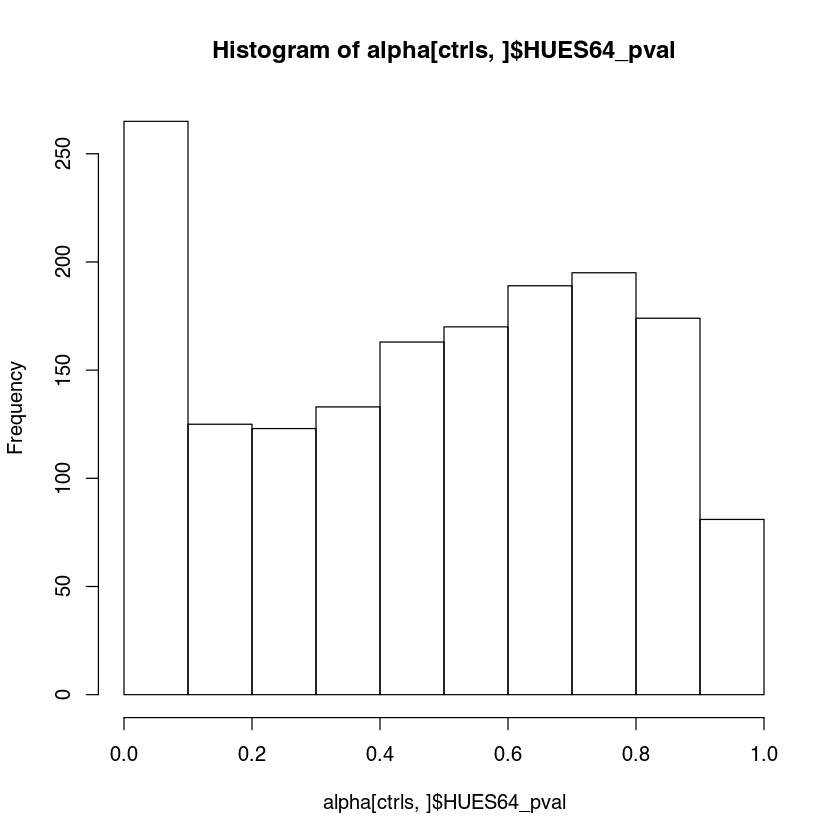

In [27]:
# histogram for negative controls
hist(alpha[ctrls,]$HUES64_pval)

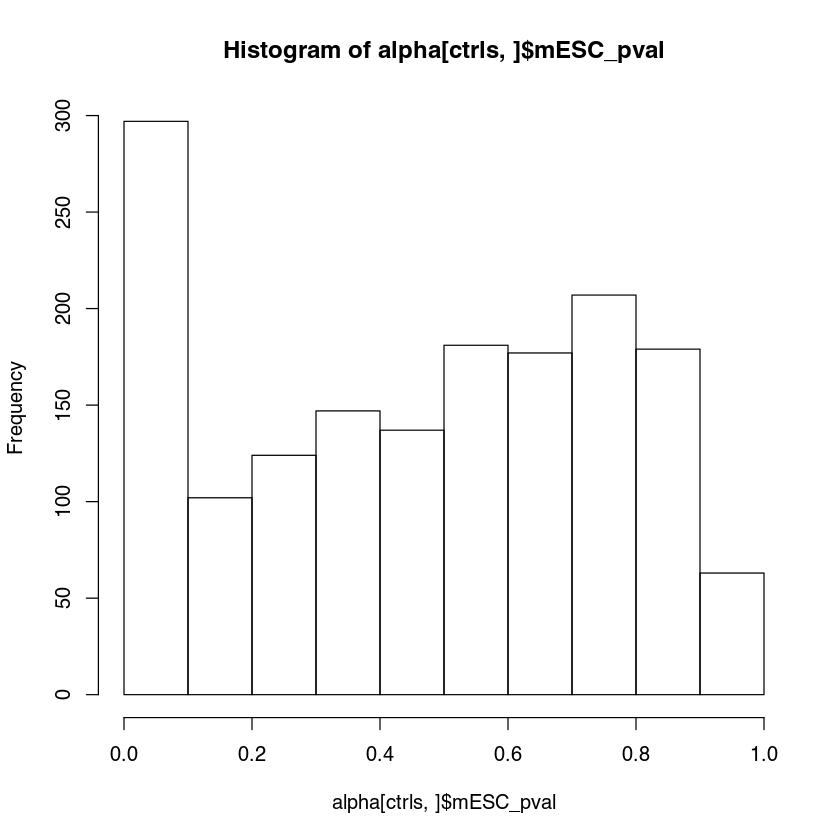

In [28]:
# histogram for negative controls
hist(alpha[ctrls,]$mESC_pval)

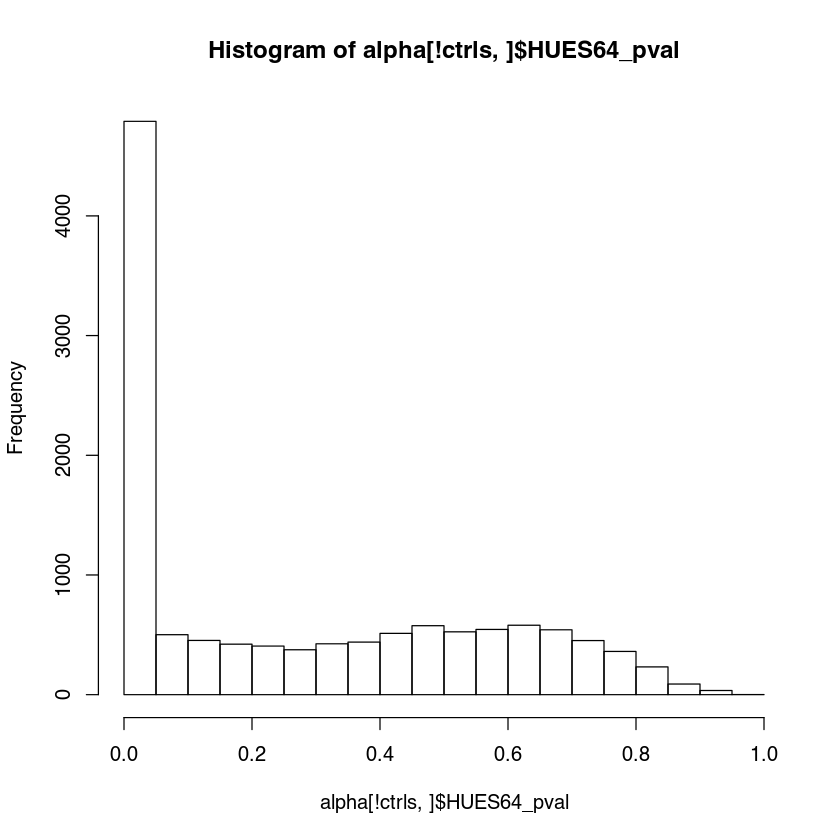

In [29]:
# histogram for TSSs
hist(alpha[!ctrls,]$HUES64_pval)

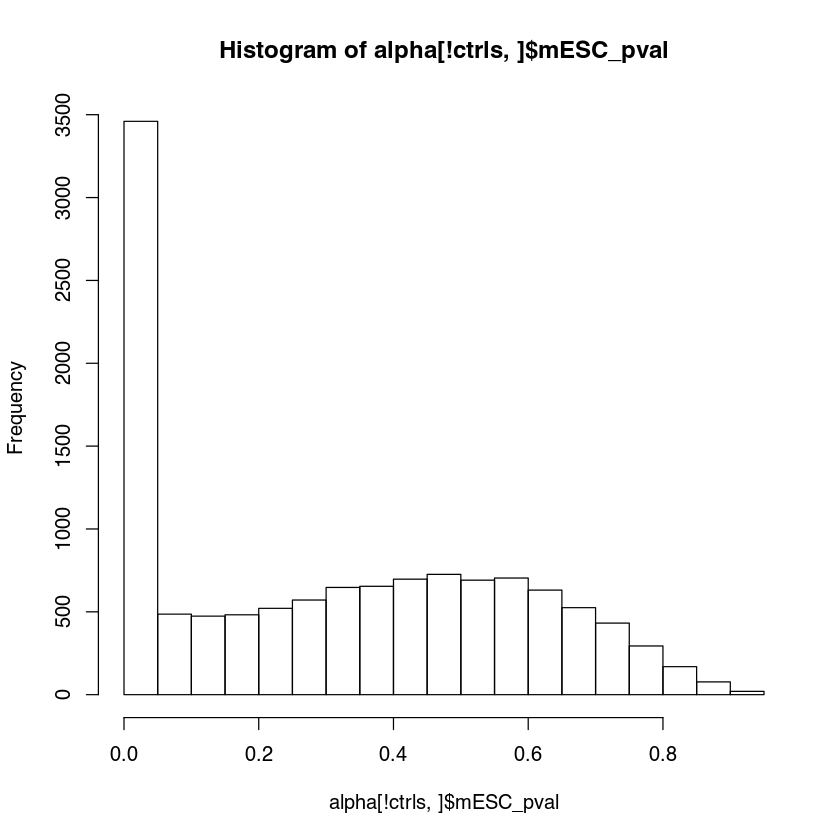

In [30]:
# histogram for TSSs
hist(alpha[!ctrls,]$mESC_pval)

In [31]:
# correct for multiple testing
alpha$HUES64_padj <- p.adjust(alpha$HUES64_pval, method = "fdr")
alpha$mESC_padj <- p.adjust(alpha$mESC_pval, method = "fdr")
head(alpha)

,HUES64,mESC,HUES64_pval,mESC_pval,HUES64_padj,mESC_padj
AAAAAAAAAAAAAAAAACCCTGCAGAGAGCCTGCAAAGTCACTGCCGGAAGTCCCTCCGCGGTGACGAGCACGGCGGAAGTGGGTTCAATGCAGCTCCCCGAAGAACTGTCTCACTCCCGCTCGCCTGACTTCTGGATGGGAGG,2.3079720,1.9652892,6.836813e-66,3.296419e-24,1.196572e-64,4.966103e-23
AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAGGGGAAGTTTCAAAGGGTGTGCCGGGGACCGGGGAAGAGTCTCATTCTCATGAGTCAGCGGATCCGGCCCAGTGTGACTTCACTGCTTCCCCAGAAGAG,0.5739228,0.4854771,7.714719e-03,1.168301e-01,2.558485e-02,3.666646e-01
AAAAAAAAAAAAGAGGAGAAATAGATTGTTACCTTATATTATTTAAACTTTCAAATGTGCTAGGGTTCCTGGAATTTGGAGAGGGAACCGAAAGGGTTTTATGGTTCTTGGGAGACAGCAGAGCACAAAGAGCCAGGGGGTGGA,0.3151899,0.2953616,4.085087e-01,4.806001e-01,6.631957e-01,7.220042e-01
AAAAAAAAAACCGGCAAAATGTCCTTTTCCTTGTTTTGAAAAGACTGGAAAATTCATCCCTGCAACCTTCCCTCCCATTTCACTGGTCAGAGTAAAAATTGGAAGTAGGAAAATTAGTACCACCACATCCTTTGAGTCAGAGAC,0.2355472,0.1774073,6.711073e-01,7.454044e-01,7.826055e-01,8.000145e-01
AAAAAAAAAGGCCACGCTCAAAACCCCAGACTAGTTTTCCTCACCAGATTCTGATGGGACGATGTCTCAGTAGCACCGCCAATGTGTGTGTAATTGACTGATCCAGTCAGTAGGGGGCCTGACTCCACAACGTTCAAGAGAATC,0.4311798,0.3763514,1.124697e-01,2.962260e-01,2.746731e-01,6.347699e-01
AAAAAAAAATGAGAAGTGTTTAAGACAGCGCAACATTACAATAGAATATTGCCTTGTTTTCTTTCTGGTTCTTCTGTCTCACAGAAATTTCTGTAAGTTCACTCCCTCAGAGGGGAAAAGGCAAGGACACAAGCAAGAGAATGA,0.3708518,0.3604878,2.411257e-01,3.299803e-01,4.821990e-01,6.590580e-01


## 5. write alphas to file

In [33]:
write.table(alpha, file = "../../../data/02__mpra/02__activs/alpha_per_elem.quantification.txt", sep = "\t",
            quote = FALSE)